<a href="https://colab.research.google.com/github/akamojo/QRS-Detector/blob/master/TransferLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignment part 1

**Student**: António Coelho - MAEBD - 54575 <br>
**Student**: Urszula Barbara Walińska - MIEI - 56556 <br>
**Teacher**: Rui Rodrigues <br>
**Course**: Aprendizagem com dados não estruturados <br>
**Date of delivery**: 07/06/2019

The objetive of this work is to: 
  1.  Train a neuralnetwork model on the MNIST dataset (digits).
  2.  Use the same mode to recognize handwritten letters.
  3.  Compare the results of using transfer learning with learning all the weights from scratch on the training set.

In [0]:
from numpy import genfromtxt
import tensorflow as tf
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Input
from sklearn.decomposition import PCA
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import StratifiedKFold

# 1. Training a neuralnetwork model on the MNIST dataset (digits)

In [0]:
# load data (X sets are images and Y sets are the true classes of the examples)
# it is already divided into train set and test set 

# evaluating result of learning on test set after each epoch
# will help us to prevent from overfitting

((trainX, trainY), (testX, testY)) = keras.datasets.mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# transforming the labels into a proper representation for learning
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

inputs = Input(shape=(28,28,1),name='inputs')

# Convolutional Layer with 32 filters, kernel of size (3,3), 
# "same" padding which results in the output with the same length as the original input, 
layer = Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1))(inputs)
layer = Activation("relu")(layer)

# Batch Normalization to force each layer to readjust mean and standard deviation after each iteration
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(32, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)

# MaxPooling of size (2,2) to aggregate the outputs in a single output for each region
layer = MaxPooling2D(pool_size=(2, 2))(layer)

# Dropout with the probability of 0.25 for regularization -> some neurons are dropped randomly
layer = Dropout(0.25)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)

features = Flatten(name='features')(layer)
layer = Dense(512)(features)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(10)(layer)
layer = Activation("softmax")(layer)
old_model = Model(inputs = inputs, outputs = layer)

INIT_LR = 0.01
NUM_EPOCHS = 5
BS = 10

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
old_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

old_model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=BS, epochs=NUM_EPOCHS)
old_model.save_weights('digits_model.h5')

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 47s 786us/sample - loss: 0.2351 - acc: 0.9333 - val_loss: 0.0418 - val_acc: 0.9863
Epoch 2/5
60000/60000 [==============================] - 42s 706us/sample - loss: 0.1234 - acc: 0.9636 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 3/5
60000/60000 [==============================] - 41s 686us/sample - loss: 0.1056 - acc: 0.9678 - val_loss: 0.0337 - val_acc: 0.9883
Epoch 4/5
60000/60000 [==============================] - 43s 712us/sample - loss: 0.1030 - acc: 0.9690 - val_loss: 0.0322 - val_acc: 0.9892
Epoch 5/5
60000/60000 [==============================] - 41s 678us/sample - loss: 0.0951 -

In the code above we download MNIST dataset, then preprocess our data to be able to use them in the training and evaluation of results.<br><br>

Then we create Neural Network model using Keras Functional API. We use several Convolutional Layers to be able to extract from the pictures of digits relevant features that will be useful later, in classification.<br>
To prevent from overfitting we use also Dropout layers. To prevent from vanishing gradients problem we use ReLU activation function. <br>
In the end we attach to our convolutional network the dense part, which consists of several Dense layers and BatchNormalization and Dropout.<br>
Of course the output layer consists of 10 neurons and softmax activation function to be able to perform the classification of 10 digits.<br><br>

As a loss function in our model we use categorical cross-entropy. We use also customized Stochastic Gradient Descent as optimizer (with weight decay to prevent from problems with convergence). The metric that allows us to evaluate the results of our solution is accuracy.<br>
After 5 epochs it reaches 99% on validation dataset.<br><br>

At the end we save the weights of our model to be able to use them in the process of Transfer Learning.

# 2. Using the same mode to recognize handwritten letters

We can take advantage from the model trained and saved before in the similar multi classification problem. This process is called Transfer Learning. It is used when 2 different tasks share relevant factors. In this case we will use the previous model build for classifying digits to classify letters.<br><br>

First, we download our data using HTTP request.

In [0]:
from io import BytesIO
from urllib.request import urlopen

resp = urlopen("https://docentes.fct.unl.pt/rapr/files/transferlearningdata.zip")
data = np.load(BytesIO(resp.read()))

In [0]:
trainX = data['imagesLettersTrain.npy']
trainY = data['labelsTrain.npy']
testX = data['imagesLettersTest.npy']
testY = data['labelsTest.npy']

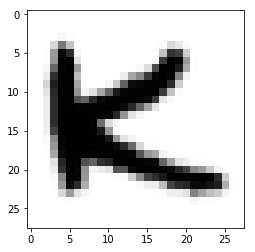

In [0]:
from matplotlib import pyplot as plt

plt.imshow(testX[90].reshape(28, 28),cmap='Greys')

Exemplary letter that we are going to classify.

In [0]:
# data preprocessing as before

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

trainY = keras.utils.to_categorical(trainY.astype("int"), 26)
testY = keras.utils.to_categorical(testY.astype("int"), 26)

In [0]:
old_model.compile(optimizer=SGD(), loss='mse')

# using weights from previous task
old_model.load_weights('digits_model.h5')

# prevent the layers from previous model from training
for layer in old_model.layers:
    layer.trainable = False

# attaching new dense network to the previous convolution network
layer = Dense(512)(old_model.get_layer('features').output)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(26)(layer)
layer = Activation("softmax")(layer)
model = Model(inputs = old_model.get_layer('inputs').output, outputs = layer)

INIT_LR = 0.01
NUM_EPOCHS = 20
BS = 50

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

# using the obtained model to fit into new data
H = model.fit(trainX, trainY, batch_size=BS, epochs=NUM_EPOCHS)

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba

In [0]:
scores = model.evaluate(testX, testY, batch_size=BS)

103080/103080 [==============================] - 5s 49us/sample - loss: 0.9138 - acc: 0.7673


As we can see, we managed to reduce slightly the number of trainable parameters by using model built for the previous problem. Moreover we managed to achieve the accuracy on test set equal 77%.

# 3. Comparison of the results using transfer learning with learning all the weights from scratch on the training dataset (letters)

In [0]:
inputs = Input(shape=(28,28,1),name='inputs')
layer = Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1))(inputs)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(32, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)

features = Flatten(name='features')(layer)
layer = Dense(512)(features)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(26)(layer)
layer = Activation("softmax")(layer)
new_model = Model(inputs = inputs, outputs = layer)

INIT_LR = 0.01
NUM_EPOCHS = 20
BS = 10

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

new_model.fit(trainX, trainY, batch_size=BS, epochs=NUM_EPOCHS)

Epoch 1/20
520/520 [==============================] - 1s 2ms/sample - loss: 3.3122 - acc: 0.2538
Epoch 2/20
520/520 [==============================] - 0s 667us/sample - loss: 2.2457 - acc: 0.4519
Epoch 3/20
520/520 [==============================] - 0s 665us/sample - loss: 1.8519 - acc: 0.5192
Epoch 4/20
520/520 [==============================] - 0s 680us/sample - loss: 1.4620 - acc: 0.5885
Epoch 5/20
520/520 [==============================] - 0s 665us/sample - loss: 1.2929 - acc: 0.6365
Epoch 6/20
520/520 [==============================] - 0s 669us/sample - loss: 1.2164 - acc: 0.6788
Epoch 7/20
520/520 [==============================] - 0s 676us/sample - loss: 1.0616 - acc: 0.6827
Epoch 8/20
520/520 [==============================] - 0s 662us/sample - loss: 0.9819 - acc: 0.7269
Epoch 9/20
520/520 [==============================] - 0s 659us/sample - loss: 0.7665 - acc: 0.7462
Epoch 10/20
520/520 [==============================] - 0s 681us/sample - loss: 0.6426 - acc: 0.7981
Epoch 11/20

In [0]:
scores = new_model.evaluate(testX, testY, batch_size=BS)

103080/103080 [==============================] - 23s 225us/sample - loss: 1.7395 - acc: 0.6421


As we can see, taking advantage from the previously trained model (for digits classification) resulted in higher accuracy result (77%) than learning all the weights from scratch on letters training dataset (64%). It is caused by the fact that given letters training (and validation) set was very small (520 examples for 26 letters, upper and lower case). On the other hand, a large test set of letters was provided. The convolutional network from model trained by learning weights from scratch did not manage to extract relevant features from data. Using the combination of already trained convolutional network (when the problem of classification is simillar) and new dense part of the network for this purpose gives us new opportunities and enables us to achieve satisfying results.